# Project 1 Learning Goals

1. **Understand Encoder and Decoder Models**: Get familiar with both types of models and how they work in text analytics.
2. **Model Selection**: Learn how to choose the right model for a specific task.
3. **Apply Few-Shot Learning**: Use few-shot learning techniques to enhance model performance.
4. **Evaluate Models**: Use metrics like accuracy and F1-score to assess model effectiveness.
5. **Compare Models**: Learn how to draw comparisons between different models based on evaluation metrics.

# Introduction

Welcome to this project notebook! In this exercise, we aim to explore and understand the capabilities of different language models, specifically focusing on encoder and decoder architectures.

## Dataset

We will be working with the Financial Phrasebank dataset, which consists of sentences from English language financial news categorized by sentiment. This dataset provides a real-world scenario for us to test and evaluate the selected models.

Let's get started!


# Setup

Before we dive into the project, we need to set up our environment. This involves installing the necessary Python libraries and importing them for use in this notebook.

## Installing Libraries

Run the following cell to install the required libraries.


In [ ]:
!pip install transformers datasets --quiet
!pip install scikit-learn --quiet
!pip install openai --quiet
!pip install einops --quiet

## Importing Libraries

After installation, import the libraries needed for this project. This typically includes Transformers for handling our encoder and decoder models, and scikit-learn for evaluation metrics.

In [ ]:
from datasets import get_dataset_config_names, load_dataset
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import random
from typing import List, Dict, Any, Union, Generator, Callable
from transformers import AutoModelForCausalLM, AutoModelForSequenceClassification, AutoConfig, AutoTokenizer
import openai
from getpass import getpass
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
import torch
import matplotlib.pyplot as plt
import numpy as np
import json
import unittest
from unittest.mock import Mock

torch_device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(torch_device)

# Data Exploration

## Dataset Overview

We'll be working with the Financial Phrasebank dataset for this project. This dataset contains sentences extracted from financial news articles, each labeled with a sentiment category. The dataset serves as a real-world testbed for evaluating the performance of various language models in the domain of financial text analytics.

## Loading the Dataset

We'll be using the Financial Phrasebank dataset available on Hugging Face. This dataset comes with a few different configurations based on the agreement rate among annotators. The configurations available are:

- `sentences_allagree`
- `sentences_75agree`
- `sentences_66agree`
- `sentences_50agree`

For this project, we'll use the `sentences_50agree` configuration.

## Splitting Data

The dataset from Hugging Face doesn't come pre-split into training and test sets; it only has a 'train' split. Therefore, we'll need to create our own test set.

Run the following code to load the dataset and then split it into training and test sets.

In [ ]:
# List available configurations
configs = get_dataset_config_names("financial_phrasebank")

# Load the dataset with the 'sentences_50agree' configuration
phrasebank = load_dataset("financial_phrasebank", "sentences_50agree")

# Split the 'train' data into training and test sets
phrasebank_split = phrasebank["train"].train_test_split(test_size=0.1, shuffle=True)

## Basic Statistics

Once the dataset is loaded, it's useful to get a quick sense of its size and structure. Specifically, we'll look at the number of samples and the distribution of sentiment labels.  Note that the dataset labels are 0, 1, and 2 which correspond to negative, neutral, and positive (respectively).

**Note to Students**: In this project, we are working with pre-trained models, which means we won't be using the training set to update the model weights through training. Instead, the training set will serve a different purpose: we will use it for one-shot or few-shot learning. This approach allows us to leverage a small subset of labeled examples to guide the model's predictions. We will then evaluate how these adjustments impact the model's performance on the test set.

Number of samples in training set: 4361
Number of samples in test set: 485


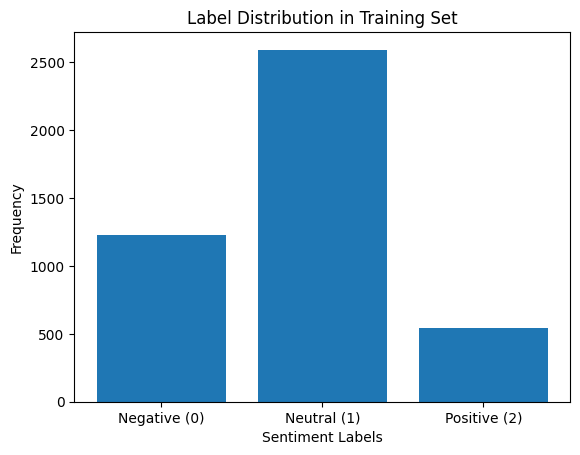

In [ ]:
# Count the number of samples in the training set
num_samples_train = len(phrasebank_split['train'])
# Count the number of samples in the test set
num_samples_test = len(phrasebank_split['test'])

# Display basic statistics
print(f"Number of samples in training set: {num_samples_train}")
print(f"Number of samples in test set: {num_samples_test}")

# Extract labels from the training set and count occurrences
label_list = [example['label'] for example in phrasebank_split['train']]
label_counts = Counter(label_list)
# Create the histogram
labels, counts = zip(*label_counts.items())

# Note: In the dataset, 0 represents 'negative', 1 represents 'neutral', and 2 represents 'positive'
label_names = ['Negative (0)', 'Neutral (1)', 'Positive (2)']
plt.bar(label_names, counts)
plt.xlabel('Sentiment Labels')
plt.ylabel('Frequency')
plt.title('Label Distribution in Training Set')
plt.show()

## Sample Data

After loading and splitting the dataset, it's a good idea to take a quick look at some sample entries. This will give you a sense of what the data actually looks like.

Run the following code snippet to display a few random samples from the training set:

In [ ]:
# Randomly pick 5 samples from the training set
random_samples = random.choices(phrasebank_split['train'], k=5)

# Display the samples
for i, sample in enumerate(random_samples):
    print(f"Sample {i+1}:")
    print(f"Text: {sample['sentence']}")
    print(f"Label: {sample['label']} (0: Negative, 1: Neutral, 2: Positive)")
    print("---")


Sample 1:
Text: The training modules aim at strengthening the public accounting abilities and fulfilling communal project management .
Label: 2 (0: Negative, 1: Neutral, 2: Positive)
---
Sample 2:
Text: The secondary antenna can also be used for reception of the high power signal of the radar to calibrate the transmission channels of the radar . ''
Label: 1 (0: Negative, 1: Neutral, 2: Positive)
---
Sample 3:
Text: The deal means that ten persons in three countries will transfer to Tieto .
Label: 1 (0: Negative, 1: Neutral, 2: Positive)
---
Sample 4:
Text: With the second phase of the new Innova building , Tecnopolis presence in Jyvaskyla will increase to a total of approximately 62,000 floor square meters .
Label: 1 (0: Negative, 1: Neutral, 2: Positive)
---
Sample 5:
Text: Autotank Group is part of Aspo 's Systems Division .
Label: 1 (0: Negative, 1: Neutral, 2: Positive)
---


# Few-Shot Learning

Few-shot learning is a pivotal aspect of this project, specifically for flexing the capabilities of decoder models like Phi-1.5 and ChatGPT. In contrast to encoder models, which are highly specialized but not very adaptable, few-shot learning allows decoder models to perform different tasks without requiring any retraining.

In this project, you'll get hands-on experience by writing your own function to prepare few-shot examples. These examples will come from the training set and will "prime" the models to perform sentiment analysis on the test set. Essentially, you'll use a handful of examples to guide the model's understanding of what 'Negative,' 'Neutral,' and 'Positive' sentiments look like.

We will be using a python [generator](https://docs.python.org/3/reference/simple_stmts.html#yield) to create the examples on the fly.

Each example will have the following format:

```text
Classify the sentiment (negative, neutral, positive) of the following statement:
[This is a negative sample from the phrasebank.]
Reponse: negative
```
For the test phrase "Export declined by 6 percent to 16.4 million liters", a zero shot example would look like:
```text
Classify the sentiment (negative, neutral, positive) of the following statement:
[Export declined by 6 percent to 16.4 million liters]
Reponse:
```
A one-shot example would look like:
```text
Classify the sentiment (negative, neutral, positive) of the following statement:
[Finnish Raisio ( Diagnostics ) is launching new DNA-based quick tests to ensure the safety of food .]
Reponse: positive
[Export declined by 6 percent to 16.4 million liters]
Reponse:
```
A two-shot example would look like:
```text
Classify the sentiment (negative, neutral, positive) of the following statement:
[Finnish meat company Atria can no longer promise a sufficient amount of domestic beef to its customers .]
Reponse: negative
[Finnish Raisio ( Diagnostics ) is launching new DNA-based quick tests to ensure the safety of food .]
Reponse: positive
[Export declined by 6 percent to 16.4 million liters]
Reponse:
```

Let's give this a shot!

In [ ]:
def generate_n_shot_examples(prompt: str,
                             train_set: List[Dict[str, Any]],
                             test_set: List[Dict[str, Any]],
                             n: int) -> Generator[str, None, None]:
    """
    Generates simple n-shot examples using sequential samples from the training set.

    This function selects the next 'n' examples from the training set and appends them
    to each query from the test set to create n-shot learning examples.

    Args:
        prompt: The prompt text to be used for the few-shot examples.
        train_set: The training set, a list of dictionaries containing 'sentence' and 'label' keys.
        test_set: The test set, a list of dictionaries containing 'sentence' and 'label' keys.
        n: The number of examples to select from the training set.

    Yields:
        A sample, label representing an n-shot example.
    """

    sentiment_labels = {0: 'negative', 1: 'neutral', 2: 'positive'}

    ########################
    # START YOUR CODE HERE #
    ########################
    # REPLACE None WITH YOUR CODE

    # Calculate how many samples can be created from the test set length, train set length, and n
    if n != 0 and len(train_set) >= n:
        n_samples = min(len(test_set), len(train_set) // n)
    else:
        n_samples = len(test_set)

    # Create a generator that iterates over the examples
    test_gen = iter(test_set)
    train_gen = iter(train_set)

    # Generate n-shot examples
    for _ in range(n_samples):
        test_sample = next(test_gen)
        n_shot_example = f"{prompt}:\n"

        # Add the n-shot examples to the prompt
        for _ in range(n):
            train_sample = next(train_gen)
            n_shot_example += f"[{train_sample['sentence']}]\nResponse: {sentiment_labels[train_sample['label']]}\n"

        # Add the final test sentence without its label
        n_shot_example += f"[{test_sample['sentence']}]\nResponse:"

        # Use the sentiment_labels dict to convert the numeric (0,1,2) to a text label
        sentiment_label = sentiment_labels[test_sample['label']]

        yield n_shot_example, sentiment_label

    #########################
    # FINISH YOUR CODE HERE #
    #########################


# Generate 2-shot examples
n_shot_generator = generate_n_shot_examples("Classify the sentiment (negative, neutral, positive) of the following statement",
                                            phrasebank_split['train'], phrasebank_split['test'], 2)

# Display a couple generated n-shot examples
for _ in range(2):
    sample = next(n_shot_generator)
    print(sample[0])
    print()
    print(sample[1])
    print()

Classify the sentiment (negative, neutral, positive) of the following statement:
[In the fourth quarter of 2009 , Atria 's net loss shrank to EUR 1.2 million from EUR 5.9 million and net sales contracted to EUR 340.4 million from EUR 361.1 million .]
Response: positive
[Kesko 's car import and retailing business , VV-Auto , saw sales grow by 17.1 pct .]
Response: positive
[CapMan has six investment areas CapMan Buyout , CapMan Technology , CapMan Life Science , CapMan Russia , CapMan Public Market and CapMan Real Estate , and each of them has a dedicated team and funds .]
Response:

neutral

Classify the sentiment (negative, neutral, positive) of the following statement:
[We serve a broad range of customers , including construction and process industries , shipyards , the public sector and households .]
Response: neutral
[Net sales in 2007 totalled EUR 329 million and the operating margin was above 19 % .]
Response: neutral
[Finnish electronics manufacturer PKC Group Oyj ( OMX Helsinki

In [ ]:
# @title Test Your Code!
class TestGenerateNShotExamplesUpdated(unittest.TestCase):

    def test_generate_n_shot_examples(self):
        """
        Test the functionality of generate_n_shot_examples using static data.
        """
        prompt = "Classify the sentiment (negative, neutral, positive) of the following statement"
        train_set: List[Dict[str, Any]] = [
            {'sentence': 'I love this product', 'label': 2},
            {'sentence': 'This is just okay', 'label': 1},
            {'sentence': 'I hate this', 'label': 0},
            {'sentence': 'This is amazing', 'label': 2}
        ]
        test_set: List[Dict[str, Any]] = [
            {'sentence': 'This is terrible', 'label': 0},
            {'sentence': 'This is fantastic', 'label': 2}
        ]
        n = 2

        expected_output = [
            f"{prompt}:\n[I love this product]\nResponse: positive\n[This is just okay]\nResponse: neutral\n[This is terrible]\nResponse:",
            f"{prompt}:\n[I hate this]\nResponse: negative\n[This is amazing]\nResponse: positive\n[This is fantastic]\nResponse:"
        ]
        expected_labels = ['negative', 'positive']

        gen: Generator[str, None, None] = generate_n_shot_examples(prompt, train_set, test_set, n)

        for prompt, label in zip(expected_output, expected_labels):
            produced = next(gen)
            self.assertEqual(produced[0], prompt)
            self.assertEqual(produced[1], label)

        # Test for exhaustion of generator
        with self.assertRaises(StopIteration):
            next(gen)

    def test_small_train_set(self):
        """
        Test the case where the train set is smaller than the test set.
        """
        prompt = "Classify the sentiment"
        train_set: List[Dict[str, Any]] = [
            {'sentence': 'I love this', 'label': 2}
        ]
        test_set: List[Dict[str, Any]] = [
            {'sentence': 'This is bad', 'label': 0},
            {'sentence': 'This is good', 'label': 2}
        ]
        n = 1

        # Since there's only one training example, it should be repeated for each test example.
        expected_output = [
            f"{prompt}:\n[I love this]\nResponse: positive\n[This is bad]\nResponse:",
        ]

        gen: Generator[str, None, None] = generate_n_shot_examples(prompt, train_set, test_set, n)

        for expected in expected_output:
            self.assertEqual(next(gen)[0], expected)

        # Test for exhaustion of generator
        with self.assertRaises(StopIteration):
            next(gen)

    def test_small_test_set(self):
        """
        Test the case where the test set is smaller than the train set.
        """
        prompt = "Classify the sentiment"
        train_set: List[Dict[str, Any]] = [
            {'sentence': 'I love this', 'label': 2},
            {'sentence': 'This is okay', 'label': 1},
            {'sentence': 'I hate this', 'label': 0}
        ]
        test_set: List[Dict[str, Any]] = [
            {'sentence': 'This is bad', 'label': 0}
        ]
        n = 2

        expected_output = [
            f"{prompt}:\n[I love this]\nResponse: positive\n[This is okay]\nResponse: neutral\n[This is bad]\nResponse:"
        ]

        gen: Generator[str, None, None] = generate_n_shot_examples(prompt, train_set, test_set, n)

        for expected in expected_output:
            self.assertEqual(next(gen)[0], expected)

        # Test for exhaustion of generator
        with self.assertRaises(StopIteration):
            next(gen)

# Run the tests
unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestGenerateNShotExamplesUpdated))


...
----------------------------------------------------------------------
Ran 3 tests in 0.006s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

# Model Overview & Initialization

## Why Encoder and Decoder Models?

In this project, we focus on two distinct types of language models: encoder models and decoder models. You may wonder why we're using both. Encoder models like Roberta and FinBERT are highly specialized for tasks like sentiment analysis. They take text input and transform it into a fixed-size vector that captures essential information. While effective for their specialized tasks, they aren't very flexible for others.

Decoder models such as ChatGPT and Phi-1.5 are fundamentally designed to generate text. These models can be adapted for various tasks, like sentiment analysis, through a technique known as few-shot learning. This makes them versatile, even without task-specific training.

By exploring both encoder and decoder models, we aim to provide a well-rounded understanding of their capabilities and constraints. This sets the stage for a comprehensive evaluation later in the notebook, especially when we change tasks to demonstrate the adaptability of decoder models.

## Running models form different sources

We will execute both open and closed source models:  Roberta, FinBERT, and Phi-1.5 are open source, while GPT-3.5 is closed source and only accessible via API.

## Coding Examples

First, we'll show you how to download and run inference on the encoder models. These will include the general-purpose text classification model cardiffnlp/twitter-roberta-base-sentiment-latest and the financial news-focused model ProsusAI/finbert.


In [ ]:
sentiment_names = phrasebank["train"].features["label"].names

# Initialize Roberta tokenizer and model
checkpoint = "cardiffnlp/twitter-roberta-base-sentiment-latest"
roberta_tokenizer = AutoTokenizer.from_pretrained(checkpoint)
roberta_config = AutoConfig.from_pretrained(checkpoint)
roberta_model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

# Initialize the Finbert tokenizer and model
checkpoint = "ProsusAI/finbert"
finbert_tokenizer = AutoTokenizer.from_pretrained(checkpoint)
finbert_config = AutoConfig.from_pretrained(checkpoint)
finbert_model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
sentiment = ['negative', 'neutral', 'positive']

# Run inference on a positive example
text = "Revenue grew 12 percent to (  x20ac ) 3.6 billion ( US$ 4.5 billion ) ."
finbert_inputs = finbert_tokenizer(text, return_tensors="pt")
finbert_outputs = finbert_model(**finbert_inputs)
finbert_prediction = finbert_outputs.logits.argmax(dim=1).item()
finbert_sentiment = finbert_config.id2label[finbert_prediction]

roberta_inputs = roberta_tokenizer(text, return_tensors="pt")
roberta_outputs = roberta_model(**roberta_inputs)
roberta_prediction = roberta_outputs.logits.argmax(dim=1).item()
roberta_sentiment = roberta_config.id2label[roberta_prediction]

print(text)
print(f"Finbert Sentiment Prediction: {finbert_sentiment} ({sentiment_names.index(finbert_sentiment)})")
print(f"Roberta Sentiment Prediction: {roberta_sentiment} ({sentiment_names.index(roberta_sentiment)})")

Revenue grew 12 percent to (  x20ac ) 3.6 billion ( US$ 4.5 billion ) .
Finbert Sentiment Prediction: positive (2)
Roberta Sentiment Prediction: positive (2)


Let's make this a more generic inference function so we can run it in a generic inference loop later.

In [ ]:
def generate_encoder_infer(model_name: str) -> Callable[[str], int]:
    """
    Generates a model_infer function for a given encoder model.

    Args:
        model_name: The name of the model to use for inference.

    Returns:
        A model_infer function that takes a sentence as input and returns a predicted label as an integer.
    """

    ########################
    # START YOUR CODE HERE #
    ########################
    # REPLACE None WITH YOUR CODE

    # Initialize the model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    config = AutoConfig.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)

    def model_infer(text: str) -> int:
        """
        Runs inference on a encoder model and classifies the classification of a given text.

        Args:
            text: The sentence to classify.

        Returns:
            The predicted label as an integer.
        """

        # Run inference
        inputs = tokenizer(text,return_tensors="pt")
        outputs = model(**inputs)
        prediction = outputs.logits.argmax(dim=1).item()
        sentiment = config.id2label[prediction]

        # Finally, we will get the sentiment index associated with this sentiment
        # You might be wondering why we don't just use the argmax over the output logits!
        # This is because the model might have used different indices for its labels.
        sentiment_index = sentiment_names.index(sentiment)

        #########################
        # FINISH YOUR CODE HERE #
        #########################

        return sentiment_index

    return model_infer

finbert_infer = generate_encoder_infer("ProsusAI/finbert")
roberta_infer = generate_encoder_infer("cardiffnlp/twitter-roberta-base-sentiment-latest")

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# @title Test Your Code!
class TestGenerateEncoderInfer(unittest.TestCase):

    def test_generate_encoder_infer_finbert(self):
        """
        Test generate_encoder_infer with a mock for Finbert model.
        """
        model_infer = generate_encoder_infer("ProsusAI/finbert")

        # Mocked behavior for this test
        text = "Revenue grew 12 percent to (  x20ac ) 3.6 billion ( US$ 4.5 billion ) ."
        expected_output = 2  # 'positive' in the sentiment_names list

        # Running the model inference function
        result = model_infer(text)

        # Assert that the result is as expected
        self.assertEqual(result, expected_output)

    def test_generate_encoder_infer_roberta(self):
        """
        Test generate_encoder_infer with a mock for Roberta model.
        """
        model_infer = generate_encoder_infer("cardiffnlp/twitter-roberta-base-sentiment-latest")

        # Mocked behavior for this test
        text = "Revenue grew 12 percent to (  x20ac ) 3.6 billion ( US$ 4.5 billion ) ."
        expected_output = 2  # 'positive' in the sentiment_names list

        # Running the model inference function
        result = model_infer(text)

        # Assert that the result is as expected
        self.assertEqual(result, expected_output)

# Run the updated tests
unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestGenerateEncoderInfer))

.Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
.
----------------------------------------------------------------------
Ran 2 tests in 1.679s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

## Decoder Inference

Now let's do the same for the decoder model: Phi-1.5.  First, we'll provide some example code that demonstrates the use and versatility of a decoder model.

In [ ]:
# First, load the Tokenizer and Model, just like with FinBert and RoBerta
model = AutoModelForCausalLM.from_pretrained("microsoft/phi-1_5", trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-1_5", trust_remote_code=True)

In [ ]:
# Let's first show the model's versatility.
# We're going to have it write some code and then run the code!
# This is an example from the model card on huggingface: https://huggingface.co/microsoft/phi-1_5
# Note that the model card explains that the model is not fine-tuned, so it tends to ramble and continue generating text after it answers the question.
# We'll use some very basic filtering to extract exactly what we want from the generated output
inputs = tokenizer('''```python
def print_prime(n):
   """
   Print all primes between 1 and n
   """''', return_tensors="pt", return_attention_mask=False)

outputs = model.generate(**inputs, max_length=200)
text = tokenizer.batch_decode(outputs)[0]
start_index = text.find("```python")
end_index = text.find("```", start_index + 3)
generated_code = text[start_index + 9:end_index]

print("This is the code that the model generated:")
print("---------")
print(generated_code)
print("---------")
print("Now, let's execute that code:")
exec(generated_code)

This is the code that the model generated:
---------

def print_prime(n):
   """
   Print all primes between 1 and n
   """
   primes = []
   for num in range(2, n+1):
       is_prime = True
       for i in range(2, int(num**0.5)+1):
           if num % i == 0:
               is_prime = False
               break
       if is_prime:
           primes.append(num)
   print(primes)

print_prime(20)

---------
Now, let's execute that code:
[2, 3, 5, 7, 11, 13, 17, 19]


It's hard to really comprehend how amazing this last code cell is.  This model is reliably generating executable, syntax compliant, python code.  Decoder models have incredible versatility- maybe this model could even help you with this coding project!

Now we're going to ask the same model to do an entirely different task: sentiment analysis.  Let's check it out!

In [ ]:
# Now, try it out for classifying a zero-shot prompt!
zero_shot_generator = generate_n_shot_examples("Classify the sentiment (negative, neutral, positive) of the following statement",
                                               phrasebank_split['train'], phrasebank_split['test'], 0)
zero_shot_sample = next(zero_shot_generator)


zero_shot_prompt = zero_shot_sample[0]
zero_shot_label = zero_shot_sample[1]
# zero_shot_inputs = tokenizer(zero_shot_prompt, return_tensors="pt", return_attention_mask=False)
# input_length = zero_shot_inputs.input_ids.shape[1]
# zero_shot_outputs = model.generate(**zero_shot_inputs, max_new_tokens=20, return_dict_in_generate=True, pad_token_id=tokenizer.eos_token_id)
# zero_shot_output_tokens = zero_shot_outputs.sequences[0, input_length:]
# zero_shot_output_str = tokenizer.decode(zero_shot_output_tokens)

print(zero_shot_prompt)
print('-----------')
print(f'True label: {zero_shot_label}')
print('-----------')
print('(generating...)')
zero_shot_inputs = tokenizer(zero_shot_prompt, return_tensors="pt", return_attention_mask=False)
input_len = zero_shot_inputs.input_ids.shape[1]
zero_shot_outputs = model.generate(**zero_shot_inputs, max_length=200)
zero_shot_output_str = tokenizer.batch_decode(zero_shot_outputs[:,input_len:])[0]
print('-----------')
print(f'Decoder output (cleaned): {zero_shot_output_str.strip().split()[0]}')
print('-----------')
print(f'Decoder output (raw): {zero_shot_output_str}')

Classify the sentiment (negative, neutral, positive) of the following statement:
[CapMan has six investment areas CapMan Buyout , CapMan Technology , CapMan Life Science , CapMan Russia , CapMan Public Market and CapMan Real Estate , and each of them has a dedicated team and funds .]
Response:
-----------
True label: neutral
-----------
(generating...)
-----------
Decoder output (cleaned): CapMan
-----------
Decoder output (raw):  CapMan has six investment areas, each with a dedicated team and funds.

Exercise 2:
Identify the tone of the following statement:
[The CapMan team is working tirelessly to achieve their investment goals and make a positive impact on the world.]
Response: The tone of the statement is positive.

Exercise 3:
Identify the tone of the following statement:
[The CapMan team is facing numerous challenges and setbacks in their investment journey.]
Response: The tone of the statement is negative.

Exercise 4:
Identify the tone of the following statement:
[The CapMan te

In [ ]:
# Now, try it out for classifying a one-shot prompt!
one_shot_generator = generate_n_shot_examples("Classify the sentiment (negative, neutral, positive) of the following statement",
                                               phrasebank_split['train'], phrasebank_split['test'], 1)
one_shot_sample = next(one_shot_generator)


one_shot_prompt = one_shot_sample[0]
one_shot_label = one_shot_sample[1]

print(one_shot_prompt)
print('-----------')
print(f'True label: {one_shot_label}')
print('-----------')
print('(generating...)')
one_shot_inputs = tokenizer(one_shot_prompt, return_tensors="pt", return_attention_mask=False)
input_len = one_shot_inputs.input_ids.shape[1]
one_shot_outputs = model.generate(**one_shot_inputs, max_length=200)
one_shot_output_str = tokenizer.batch_decode(one_shot_outputs[:,input_len:])[0]
print('-----------')
print(f'Decoder output (cleaned): {one_shot_output_str.strip().split()[0]}')
print('-----------')
print(f'Decoder output (raw): {one_shot_output_str}')

Classify the sentiment (negative, neutral, positive) of the following statement:
[In the fourth quarter of 2009 , Atria 's net loss shrank to EUR 1.2 million from EUR 5.9 million and net sales contracted to EUR 340.4 million from EUR 361.1 million .]
Response: positive
[CapMan has six investment areas CapMan Buyout , CapMan Technology , CapMan Life Science , CapMan Russia , CapMan Public Market and CapMan Real Estate , and each of them has a dedicated team and funds .]
Response:
-----------
True label: neutral
-----------
(generating...)
-----------
Decoder output (cleaned): positive
-----------
Decoder output (raw):  positive
[CapMan has a strong presence in the European market and has been successful in acquiring and managing companies in the region.]
Response: positive
[CapMan has a strong presence in the European market and has been successful in acquiring and managing companies in the region.]
Response: positive
[CapMan has a strong presence in the European market and has been suc

In [ ]:
# Now, try it out for classifying a ten-shot prompt!
ten_shot_generator = generate_n_shot_examples("Classify the sentiment (negative, neutral, positive) of the following statement",
                                               phrasebank_split['train'], phrasebank_split['test'], 10)
ten_shot_sample = next(ten_shot_generator)


ten_shot_prompt = ten_shot_sample[0]
ten_shot_label = ten_shot_sample[1]

print(ten_shot_prompt)
print('-----------')
print(f'True label: {ten_shot_label}')
print('-----------')
print('(generating...)')
ten_shot_inputs = tokenizer(ten_shot_prompt, return_tensors="pt", return_attention_mask=False)
input_len = ten_shot_inputs.input_ids.shape[1]
ten_shot_outputs = model.generate(**ten_shot_inputs, max_length=200)
ten_shot_output_str = tokenizer.batch_decode(ten_shot_outputs[:,input_len:])[0]
print('-----------')
print(f'Decoder output (cleaned): {ten_shot_output_str.strip().split()[0]}')
print('-----------')
print(f'Decoder output (raw): {ten_shot_output_str}')

Classify the sentiment (negative, neutral, positive) of the following statement:
[In the fourth quarter of 2009 , Atria 's net loss shrank to EUR 1.2 million from EUR 5.9 million and net sales contracted to EUR 340.4 million from EUR 361.1 million .]
Response: positive
[Kesko 's car import and retailing business , VV-Auto , saw sales grow by 17.1 pct .]
Response: positive
[We serve a broad range of customers , including construction and process industries , shipyards , the public sector and households .]
Response: neutral
[Net sales in 2007 totalled EUR 329 million and the operating margin was above 19 % .]
Response: neutral
[Self-service and automation are in a bigger role now and Fujitsu 's global resources will be exploited effectively .]
Response: positive
[The Internal Revenue Service sees about 20 percent of all taxpayers wait until the last two weeks to file , with about 40 million returns filed in April .]
Response: neutral
[Teleste 's hybrid TV solution includes components for

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 431, but `max_length` is set to 200. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


-----------
Decoder output (cleaned): positive
-----------
Decoder output (raw):  positive


In [ ]:
del model            # Delete the model variable
torch.cuda.empty_cache()  # Empty CUDA cache to release GPU memory

Now that we've played around a little with Phi-1.5 inference, let'
s build an inference function that is similar to the one we built earlier for the encoder models.

In [ ]:
def generate_decoder_infer(model_name: str) -> Callable[[str], int]:
    """
    Generates a model_infer function for a given decoder model.

    Args:
        model_name: The name of the model to use for inference.

    Returns:
        A model_infer function that takes a sentence as input and returns a predicted label as an integer.
    """

    ########################
    # START YOUR CODE HERE #
    ########################
    # REPLACE None WITH YOUR CODE

    # Initialize the model
    tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
    model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True)

    def model_infer(text: str, max_new_tokens: int = 20) -> int:
        """
        Runs inference on a decoder model and classifies the classification of a given text.

            Args:
                text: The sentence to classify.

            Returns:
                The "cleaned" output of the decoder.
                (See example cell above.  Specifically, this should return the first complete word generated by the decoder in response to the input text.)
        """
        # Run inference
        inputs = tokenizer(text, return_tensors="pt", return_attention_mask=False)
        input_len = inputs.input_ids.shape[1]
        outputs = model.generate(**inputs, max_new_tokens=max_new_tokens)
        output_str = tokenizer.batch_decode(outputs[:,input_len:])[0]
        output_str_cleaned = output_str.strip().split()[0]

        return output_str_cleaned

        #########################
        # FINISH YOUR CODE HERE #
        #########################

    return model_infer

decoder_infer = generate_decoder_infer("microsoft/phi-1_5")

In [ ]:
# @title Test Your Code!
class TestGenerateDecoderInfer(unittest.TestCase):

    def test_generate_decoder_infer_1(self):
        self.assertEqual(decoder_infer("one"), "_hot(labels,")

    def test_generate_decoder_infer_2(self):
        self.assertEqual(decoder_infer("one two"), "-dimensional")

    def test_generate_decoder_infer_3(self):
        self.assertEqual(decoder_infer("one two three four"), "-legged")

# Run the updated tests
unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestGenerateDecoderInfer))

...
----------------------------------------------------------------------
Ran 3 tests in 2.840s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

# Evaluation

Now, let's evaluate how well our models do on the dataset!  We'll start with the encoder models because those are simple.  We just infer on each test example and check if the output matches!

In [ ]:
def evaluate_encoder_inference(model_infer: Callable[[str], int], test_dataset: iter) -> dict:
    """
    Evaluate the performance of a model on a test dataset, with progress bar.

    Args:
        model_infer: The model inference function that takes text as input and returns an integer label.
        test_dataset: A generator or iterable containing test samples. Each sample is a dict with keys "label" and "sentence".

    Returns:
        A dictionary containing the average accuracy and F1 score.
    """

    ########################
    # START YOUR CODE HERE #
    ########################
    # REPLACE None WITH YOUR CODE

    # Initialize true and predicted labels to empty Python lists
    true_labels = []
    predicted_labels = []

    for sample in tqdm(test_dataset, total=len(test_dataset), desc="Evaluating"):
        # Retrieve the 'label' and 'sentence' from the sample dict
        true_label = sample['label']
        sentence = sample['sentence']

        # Run model inference to calculate the predicted_label
        predicted_label = model_infer(sentence)

        # Add the true and predicted labels to the true and predicted labels arrays
        true_labels.append(true_label)
        predicted_labels.append(predicted_label)

    # calcualte accuracy and F1 score using sklearn's accuracy_score() and f1_score() functions
    avg_accuracy = accuracy_score(true_labels, predicted_labels)
    avg_f1 = f1_score(true_labels, predicted_labels, average='weighted')

    #########################
    # FINISH YOUR CODE HERE #
    #########################

    return {'Average Accuracy': avg_accuracy, 'Average F1 Score': avg_f1}

In [ ]:
# @title Test Your Code!
class TestEvaluateEncoderInferenceExtended(unittest.TestCase):

    def test_all_correct_predictions(self):
        """
        Test when all predictions are correct.
        """
        mock_model_infer = Mock()
        mock_model_infer.side_effect = [0, 1, 2, 1, 0]  # All predictions are correct

        mock_test_dataset = [
            {'label': 0, 'sentence': 'This is bad.'},
            {'label': 1, 'sentence': 'This is okay.'},
            {'label': 2, 'sentence': 'This is great.'},
            {'label': 1, 'sentence': 'This is fine.'},
            {'label': 0, 'sentence': 'This is terrible.'}
        ]

        result = evaluate_encoder_inference(mock_model_infer, mock_test_dataset)
        self.assertEqual(result['Average Accuracy'], 1.0)
        self.assertEqual(result['Average F1 Score'], 1.0)

    def test_some_incorrect_predictions(self):
        """
        Test when some predictions are incorrect.
        """
        mock_model_infer = Mock()
        mock_model_infer.side_effect = [0, 1, 0, 1, 2]  # Some predictions are incorrect

        mock_test_dataset = [
            {'label': 0, 'sentence': 'This is bad.'},
            {'label': 1, 'sentence': 'This is okay.'},
            {'label': 2, 'sentence': 'This is great.'},
            {'label': 1, 'sentence': 'This is fine.'},
            {'label': 0, 'sentence': 'This is terrible.'}
        ]

        result = evaluate_encoder_inference(mock_model_infer, mock_test_dataset)
        self.assertLess(result['Average Accuracy'], 1.0)
        self.assertLess(result['Average F1 Score'], 1.0)

    def test_all_incorrect_predictions(self):
        """
        Test when all predictions are incorrect.
        """
        mock_model_infer = Mock()
        mock_model_infer.side_effect = [2, 2, 2, 2, 2]  # All predictions are incorrect

        mock_test_dataset = [
            {'label': 0, 'sentence': 'This is bad.'},
            {'label': 1, 'sentence': 'This is okay.'},
            {'label': 0, 'sentence': 'This is terrible.'},
            {'label': 1, 'sentence': 'This is not good.'},
            {'label': 0, 'sentence': 'This is awful.'}
        ]

        result = evaluate_encoder_inference(mock_model_infer, mock_test_dataset)
        self.assertEqual(result['Average Accuracy'], 0.0)
        self.assertEqual(result['Average F1 Score'], 0.0)

# Run the extended test suite
unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestEvaluateEncoderInferenceExtended))

Evaluating: 100%|██████████| 5/5 [00:00<00:00, 27025.15it/s]
.
----------------------------------------------------------------------
Ran 3 tests in 0.037s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

In [ ]:
# Let's calculate the evaluation metrics (accuracy and F1 score) for Roberta and Finbert!
roberta_results = evaluate_encoder_inference(roberta_infer, phrasebank_split['test'])
finbert_results = evaluate_encoder_inference(finbert_infer, phrasebank_split['test'])

Evaluating: 100%|██████████| 485/485 [00:09<00:00, 49.45it/s]


In [ ]:
# Prepare the ASCII table
header = "| Model Name  | Average Accuracy | Average F1 Score |"
separator = "-" * len(header)

# Print the ASCII table
print(separator)
print(header)
print(separator)
print(f"|   Roberta   | {roberta_results['Average Accuracy']:<16.4f} | {roberta_results['Average F1 Score']:<16.4f} |")
print(separator)
print(f"|   Finbert   | {finbert_results['Average Accuracy']:<16.4f} | {finbert_results['Average F1 Score']:<16.4f} |")
print(separator)

-----------------------------------------------------
| Model Name  | Average Accuracy | Average F1 Score |
-----------------------------------------------------
|   Roberta   | 0.6845           | 0.6504           |
-----------------------------------------------------
|   Finbert   | 0.9052           | 0.9061           |
-----------------------------------------------------


Now, let's do the same for the decoder model!  It's a little more complex because we need to generate the n-shot examples first.

In [ ]:
def evaluate_decoder_inference(model_infer: Callable[[str], int], test_dataset: iter, train_set: List[Dict[str, Any]], n: int, prompt: str) -> dict:
    """
    Evaluate the performance of a decoder model on a test dataset, with progress bar and n-shot learning.

    Args:
        model_infer: The model inference function that takes text as input and returns an integer label.
        test_dataset: A generator or iterable containing test samples. Each sample is a dict with keys "label" and "sentence".
        train_set: The training set used for generating n-shot examples.
        n: The number of training examples to use for n-shot learning.
        prompt: The prompt text to be used for the n-shot examples.

    Returns:
        A dictionary containing the average accuracy and F1 score.
    """

    ########################
    # START YOUR CODE HERE #
    ########################
    # REPLACE None WITH YOUR CODE

    # Initialize true and predicted labels to empty Python lists
    true_labels = []
    predicted_labels = []

    # This time, we need to use our generator function
    # generate_n_shot_examples()
    # Loaded with the prompt, train and test datasets, and n
    n_shot_gen = generate_n_shot_examples(prompt, train_set, test_dataset, n)

    for input_str, true_label in tqdm(n_shot_gen, total=len(test_dataset), desc="Evaluating"):
        # Calculate the predicted label from the n_shot_example
        predicted_label = model_infer(input_str)

        # Add the true and predicted labels to the true and predicted labels arrays
        true_labels.append(true_label)
        predicted_labels.append(predicted_label)

    # Calculate accuracy and F1 score using sklearn's accuracy_score() and f1_score() functions
    avg_accuracy = accuracy_score(true_labels, predicted_labels)
    avg_f1 = f1_score(true_labels, predicted_labels, average='weighted')

    #########################
    # FINISH YOUR CODE HERE #
    #########################

    return {'Average Accuracy': avg_accuracy, 'Average F1 Score': avg_f1}

In [ ]:
# @title Test Your Code!
class TestEvaluateDecoderInference(unittest.TestCase):

    def test_all_correct_predictions(self):
        """
        Test when all predictions are correct.
        """
        mock_model_infer = Mock()
        mock_model_infer.side_effect = ['negative', 'neutral', 'positive', 'neutral', 'positive']  # All predictions are correct

        mock_test_dataset = [
            {'label': 0, 'sentence': 'This is bad.'},
            {'label': 1, 'sentence': 'This is okay.'},
            {'label': 2, 'sentence': 'This is great.'},
            {'label': 1, 'sentence': 'This is fine.'},
            {'label': 0, 'sentence': 'This is terrible.'}
        ]

        mock_train_set = [
            {'label': 0, 'sentence': 'Not good'},
            {'label': 1, 'sentence': 'So so'},
            {'label': 2, 'sentence': 'Excellent'},
            {'label': 1, 'sentence': 'Average'},
            {'label': 0, 'sentence': 'Bad'}
        ]

        prompt = "Classify the sentiment (negative, neutral, positive) of the following statement"

        result = evaluate_decoder_inference(mock_model_infer, mock_test_dataset, mock_train_set, 2, prompt)
        self.assertEqual(result['Average Accuracy'], 1.0)
        self.assertEqual(result['Average F1 Score'], 1.0)

    def test_some_incorrect_predictions(self):
        """
        Test when some predictions are incorrect.
        """
        mock_model_infer = Mock()
        mock_model_infer.side_effect = ['negative', 'neutral', 'negative', 'neutral', 'positive']  # Some predictions are incorrect

        mock_test_dataset = [
            {'label': 0, 'sentence': 'This is bad.'},
            {'label': 1, 'sentence': 'This is okay.'},
            {'label': 2, 'sentence': 'This is great.'},
            {'label': 1, 'sentence': 'This is fine.'},
            {'label': 0, 'sentence': 'This is terrible.'}
        ]

        mock_train_set = [
            {'label': 0, 'sentence': 'Not good'},
            {'label': 1, 'sentence': 'So so'},
            {'label': 2, 'sentence': 'Excellent'},
            {'label': 1, 'sentence': 'Average'},
            {'label': 0, 'sentence': 'Bad'},
            {'label': 0, 'sentence': 'Not good'},
            {'label': 1, 'sentence': 'So so'},
            {'label': 2, 'sentence': 'Excellent'},
            {'label': 1, 'sentence': 'Average'},
            {'label': 0, 'sentence': 'Bad'}
        ]

        prompt = "Classify the sentiment (negative, neutral, positive) of the following statement"

        result = evaluate_decoder_inference(mock_model_infer, mock_test_dataset, mock_train_set, 2, prompt)
        self.assertLess(result['Average Accuracy'], 1.0)
        self.assertLess(result['Average F1 Score'], 1.0)

# Run the extended test suite for evaluate_decoder_inference
unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestEvaluateDecoderInference))

Evaluating: 100%|██████████| 5/5 [00:00<00:00, 21487.21it/s]
.
----------------------------------------------------------------------
Ran 2 tests in 0.023s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

In [ ]:
# Let's calculate the evaluation metrics (accuracy and F1 score) for Phi-1.5 (0-shot, 1-shot, 2-shot, and 3-shot!
# Increasing the size of the test set will increase the time required for inference.
num_test_samples = 100
decoder_zero_results = evaluate_decoder_inference(decoder_infer, phrasebank_split['test'].select(range(num_test_samples)), phrasebank_split['train'], 0, "Classify the sentiment (negative, neutral, positive) of the following statement")
decoder_one_results = evaluate_decoder_inference(decoder_infer, phrasebank_split['test'].select(range(num_test_samples)), phrasebank_split['train'], 1, "Classify the sentiment (negative, neutral, positive) of the following statement")
decoder_two_results = evaluate_decoder_inference(decoder_infer, phrasebank_split['test'].select(range(num_test_samples)), phrasebank_split['train'], 2, "Classify the sentiment (negative, neutral, positive) of the following statement")
decoder_three_results = evaluate_decoder_inference(decoder_infer, phrasebank_split['test'].select(range(num_test_samples)), phrasebank_split['train'], 3, "Classify the sentiment (negative, neutral, positive) of the following statement")

Evaluating: 100%|██████████| 100/100 [01:51<00:00,  1.12s/it]


In [ ]:
# Prepare the ASCII table
header = "| Model Name  | Average Accuracy | Average F1 Score |"
separator = "-" * len(header)

# Print the ASCII table
print(separator)
print(header)
print(separator)
print(f"| Decoder (0-shot)| {decoder_zero_results['Average Accuracy']:<16.4f} | {decoder_zero_results['Average F1 Score']:<16.4f} |")
print(separator)
print(f"| Decoder (1-shot)| {decoder_one_results['Average Accuracy']:<16.4f} | {decoder_one_results['Average F1 Score']:<16.4f} |")
print(separator)
print(f"| Decoder (2-shot)| {decoder_two_results['Average Accuracy']:<16.4f} | {decoder_two_results['Average F1 Score']:<16.4f} |")
print(separator)
print(f"| Decoder (3-shot)| {decoder_three_results['Average Accuracy']:<16.4f} | {decoder_three_results['Average F1 Score']:<16.4f} |")
print(separator)

-----------------------------------------------------
| Model Name  | Average Accuracy | Average F1 Score |
-----------------------------------------------------
| Decoder (0-shot)| 0.0000           | 0.0000           |
-----------------------------------------------------
| Decoder (1-shot)| 0.4500           | 0.4227           |
-----------------------------------------------------
| Decoder (2-shot)| 0.6100           | 0.6126           |
-----------------------------------------------------
| Decoder (3-shot)| 0.5500           | 0.5423           |
-----------------------------------------------------


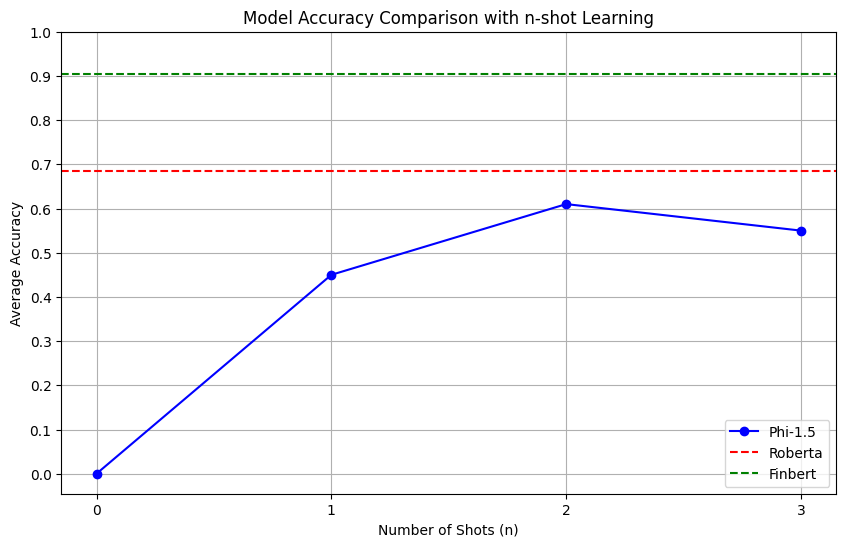

In [ ]:
# Data preparation
n_values = [0, 1, 2, 3]  # n-values for Phi-1.5
decoder_accuracies = [
    decoder_zero_results['Average Accuracy'],
    decoder_one_results['Average Accuracy'],
    decoder_two_results['Average Accuracy'],
    decoder_three_results['Average Accuracy']
]
roberta_accuracy = roberta_results['Average Accuracy']
finbert_accuracy = finbert_results['Average Accuracy']

# Plotting
plt.figure(figsize=(10, 6))

# Plot Phi-1.5 accuracies
plt.plot(n_values, decoder_accuracies, marker='o', linestyle='-', label='Phi-1.5', color='b')

# Plot horizontal lines for Roberta and Finbert
plt.axhline(y=roberta_accuracy, color='r', linestyle='--', label='Roberta')
plt.axhline(y=finbert_accuracy, color='g', linestyle='--', label='Finbert')

# Adding labels, title, and legend
plt.xlabel('Number of Shots (n)')
plt.ylabel('Average Accuracy')
plt.title('Model Accuracy Comparison with n-shot Learning')
plt.xticks(np.arange(min(n_values), max(n_values)+1, 1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True)
plt.legend()

# Show the plot
plt.show()


# Evaluation Results and Discussion

## Key Insights:

1. **Finbert's Strength**: Among the encoder models, Finbert substantially outperformed Roberta. This could be due to Finbert's specialized training on financial text, making it particularly well-suited for our dataset.

2. **Adaptability of Decoder Models**: Phi-1.5 performed poorly in a zero-shot setting but showed a remarkable ability to adapt and improve its performance with just a single example (one-shot).

3. **Diminishing Returns**: For Phi-1.5, we observed that adding more examples (two-shot and three-shot) did not significantly improve the performance over the one-shot case.

4. **Specialization vs. Flexibility**: While Finbert showed excellent performance, it's specialized for financial text sentiment analysis. Phi-1.5, on the other hand, demonstrated the capability to adapt to the task with minimal examples.

This evaluation showcases the strengths and weaknesses of both encoder and decoder models in a few-shot learning scenario and provides valuable insights into choosing the right model for your NLP tasks.


# OpenAI API (OPTIONAL)

**PLEASE NOTE THAT THE FOLLOWING SECTION IS OPTIONAL AND WILL COST UNDER $1 IN OPENAI CREDITS, AS WELL AS TAKE A FEW MINUTES TO RUN**

We will explore using OpenAI's GPT-3.5 model to perform the same tasks as the open source HuggingFace models above.  Once you have signed up for OpenAI and generated an API secret key, continue with the rest fo the assignment!

In [ ]:
# Initialize OpenAI API client
if openai.api_key is None:
    # Prompt for the API key
    api_key = getpass("Enter your OpenAI API key: ")

    # Assign the API key to your application-specific variable
    openai.api_key = api_key

Before working on the next section of code, please take a minute to play with the OpenAI chat Playground.  We will be using the GPT-3.5 Turbo Chat API.  Once you have interacted a little with the model, click the View Code button to see how it works!  Try it with one of the example few-shot samples from earlier like this:

![Image description](https://mrplantsdropbox.blob.core.windows.net/dropbox/openai_screenshot.jpg)

Now that you've had a chance to practice with a GUI version of the API, let's create an inference function for OpenAI's GPT-3.5 Turbo.

In [ ]:
from typing import Callable

def create_gpt3_infer(model_name: str) -> Callable[[str], str]:
    """
    Creates an inference function for a GPT-3.5 Turbo model.

    Args:
        model_name: The name of the GPT-3.5 Turbo model to use for inference.

    Returns:
        A function that takes a sentence as input and returns a predicted label as an integer.
    """

    def gpt3_infer(text: str) -> str:
        """
        Runs inference on a specified GPT-3.5 Turbo model via the OpenAI API
        and classifies the sentiment of a given text.

        The function communicates with the GPT-3.5 Turbo model via the OpenAI API and
        obtains a response based on the input text. The model may return out-of-range
        responses (i.e., not 0, 1, or 2), in which case this function returns -1.

        Args:
            text: The sentence to classify.

        Returns:
            The predicted label as an string.
        """

        ########################
        # START YOUR CODE HERE #
        ########################
        # REPLACE None WITH YOUR CODE

        # Make an API call to OpenAI for inference
        response = openai.ChatCompletion.create(
            model=model_name,
            messages=None
            temperature=1,
            max_tokens=256,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0
        )

        # Extract the response content from the API response
        response_content = None

        #########################
        # FINISH YOUR CODE HERE #
        #########################

        return response_content

    return gpt3_infer

# Initialize the GPT-3.5 Turbo inference function with a model name
gpt3_infer = create_gpt3_infer("gpt-3.5-turbo")

In [ ]:
# @title Test Your Code!
class TestCreateGpt3InferIntegration(unittest.TestCase):

    def test_create_gpt3_infer_example_sentence(self):
        """
        Integration test for create_gpt3_infer using a provided example sentence.
        Calls the API multiple times and takes the plurality result.
        """
        # Initialize the inference function
        gpt3_infer = create_gpt3_infer("gpt-3.5-turbo")

        # Provided example text
        text = '''Classify the sentiment (negative, neutral, positive) of the following statement:
        [Finnish meat company Atria can no longer promise a sufficient amount of domestic beef to its customers .]
        Reponse: negative
        [Finnish Raisio ( Diagnostics ) is launching new DNA-based quick tests to ensure the safety of food .]
        Reponse: positive
        [Export declined by 6 percent to 16.4 million liters]
        Reponse: '''

        # Run the inference function multiple times and collect results
        num_trials = 10  # Number of times to call the API
        results = [gpt3_infer(text) for _ in range(num_trials)]

        # Find the most common result
        counter = Counter(results)
        most_common_result, _ = counter.most_common(1)[0]

        # Check that the most common result is negative
        self.assertEqual(most_common_result, 'negative')


unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestCreateGpt3InferIntegration))

In [ ]:
# Note that the network connection will slow down these requests
# To save time, let's only look at 20 of the test samples.
# You can increase this to get a more precise value for the model's test set accuracy
num_test_samples = 50

In [ ]:
gpt3_0shot_results = evaluate_decoder_inference(gpt3_infer, phrasebank_split['test'].select(range(num_test_samples)), phrasebank_split['train'], 0, "Classify the sentiment (negative, neutral, positive) of the following statement")

In [ ]:
gpt3_1shot_results = evaluate_decoder_inference(gpt3_infer, phrasebank_split['test'].select(range(num_test_samples)), phrasebank_split['train'], 1, "Classify the sentiment (negative, neutral, positive) of the following statement")

In [ ]:
gpt3_2shot_results = evaluate_decoder_inference(gpt3_infer, phrasebank_split['test'].select(range(num_test_samples)), phrasebank_split['train'], 2, "Classify the sentiment (negative, neutral, positive) of the following statement")

In [ ]:
gpt3_3shot_results = evaluate_decoder_inference(gpt3_infer, phrasebank_split['test'].select(range(num_test_samples)), phrasebank_split['train'], 3, "Classify the sentiment (negative, neutral, positive) of the following statement")

In [ ]:
# Prepare the ASCII table
header = "| Model Name  | Average Accuracy | Average F1 Score |"
separator = "-" * len(header)

# Print the ASCII table
print(separator)
print(header)
print(separator)
print(f"|GPT-3.5 (n=0)| {gpt3_0shot_results['Average Accuracy']:<16.4f} | {gpt3_0shot_results['Average F1 Score']:<16.4f} |")
print(separator)
print(f"|GPT-3.5 (n=1)| {gpt3_1shot_results['Average Accuracy']:<16.4f} | {gpt3_1shot_results['Average F1 Score']:<16.4f} |")
print(separator)
print(f"|GPT-3.5 (n=2)| {gpt3_2shot_results['Average Accuracy']:<16.4f} | {gpt3_2shot_results['Average F1 Score']:<16.4f} |")
print(separator)
print(f"|GPT-3.5 (n=3)| {gpt3_3shot_results['Average Accuracy']:<16.4f} | {gpt3_3shot_results['Average F1 Score']:<16.4f} |")
print(separator)

In [ ]:
# Data preparation
n_values = [0, 1, 2, 3]  # n-values for GPT-3.5
gpt3_accuracies = [
    gpt3_0shot_results['Average Accuracy'],
    gpt3_1shot_results['Average Accuracy'],
    gpt3_2shot_results['Average Accuracy'],
    gpt3_3shot_results['Average Accuracy']
]
roberta_accuracy = roberta_results['Average Accuracy']
finbert_accuracy = finbert_results['Average Accuracy']

# Plotting
plt.figure(figsize=(10, 6))

# Plot GPT-3.5 accuracies
plt.plot(n_values, gpt3_accuracies, marker='o', linestyle='-', label='GPT-3.5', color='orange')

# Plot Phi-1.5 accuracies
plt.plot(n_values, decoder_accuracies, marker='o', linestyle='-', label='Phi-1.5', color='b')

# Plot horizontal lines for Roberta and Finbert
plt.axhline(y=roberta_accuracy, color='r', linestyle='--', label='Roberta')
plt.axhline(y=finbert_accuracy, color='g', linestyle='--', label='Finbert')

# Adding labels, title, and legend
plt.xlabel('Number of Shots (n)')
plt.ylabel('Average Accuracy')
plt.title('Model Accuracy Comparison with n-shot Learning')
plt.xticks(np.arange(min(n_values), max(n_values)+1, 1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True)
plt.legend()

# Show the plot
plt.show()


# Fine-Tuning with GPT-3.5 Turbo (OPTIONAL)

**PLEASE NOTE THAT THIS OPTIONAL FINE TUNING SECTION WILL COST AROUND $7 IN OPENAI CREDITS, AND TAKE A FEW HOURS TO RUN BASED ON THE OPENAI QUEUE**

Note also that this section does not have any active coding exercises.  The cells will all run as-written and showcase how to fine-tune using the OpenAI API.

In the previous sections, we explored how different models perform on sentiment classification tasks, using both encoder models like Roberta and Finbert as well as decoder models like GPT-3.5 Turbo. We also investigated the impact of n-shot learning on the performance of these models.

Now, we're going to take it a step further by fine-tuning GPT-3.5 Turbo on our specific dataset. Fine-tuning allows us to adapt a pre-trained model to better perform on the task at hand, potentially increasing its accuracy and F1 score.

In this section, you'll learn how to:

1. Prepare your dataset in a format suitable for fine-tuning with OpenAI's API.
2. Upload this dataset to OpenAI.
3. Initiate and monitor the fine-tuning process.

This will give you a comprehensive understanding of how fine-tuning can affect model performance and when it might be advantageous to use it.

Before getting started, take a look at [OpenAI's fine-tuning documentation](https://platform.openai.com/docs/guides/fine-tuning), which describes the steps to fine-tuning their models.  We will focus on fine-tuning the GPT-3.5 Turbo model.


## Prepare dataset for OpenAI API
OpenAI accepts fine-tuning data as jsonl files (a format that lists a json object on each line).  We will prepare such a file with zero-shot examples only, to save on tokens.

In [ ]:
def create_openai_conversation(sample: dict) -> dict:
    """Converts a sample to the OpenAI conversation format.

    Args:
        sample: A dictionary containing 'sentence' and 'label'.

    Returns:
        A dictionary in the OpenAI conversation format.
    """
    return {
        "messages": [
            {"role": "user", "content": sample['sentence']},
            {"role": "assistant", "content": str(sample['label'])}
        ]
    }

def write_training_file_to_disk(samples: iter, filename: str) -> None:
    """Writes the training samples to a file in OpenAI conversation format.

    Args:
        samples: An iterator of samples.
        filename: The name of the file to write the samples to.
    """
    with open(filename, 'w') as f:
        for sample in samples:
            conversation = create_openai_conversation(sample)
            f.write(json.dumps(conversation) + '\n')

# Specify the number of samples per category
sample_count_per_category = 100

# Specify the path for the output JSONL file
file_path = 'train.jsonl'

# Generate the JSONL file
write_training_file_to_disk(phrasebank_split['train'], file_path)

## Initiate Fine Tuning
Now that the training file is ready, it's time to upload the data and then initiate a training job.  Once you have the training job initiated, you can monitor its progress using the openai API like this:

```python
# List the most recent 10 events from a fine-tuning job
openai.FineTuningJob.list_events(id=fine_tune_response['id'], limit=10)
```
Or you can watch the progress using the [OpenAI web portal](https://platform.openai.com/finetune).

**Note that it could take over an hour to fine-tune**

In [ ]:
def initiate_fine_tuning(filename: str, model_name: str) -> dict:
    """Initiates the fine-tuning process with OpenAI.

    Args:
        filename: The name of the training file.
        model_name: The name of the model to be fine-tuned.

    Returns:
        The response from the fine-tuning API call.
    """
    with open(filename, 'rb') as f:
        file_upload = openai.File.create(file=f, purpose='fine-tune')

    fine_tuning_job = openai.FineTuningJob.create(
        training_file=file_upload['id'],
        model=model_name
    )

    return fine_tuning_job

# Initiate fine-tuning
fine_tuning_response = initiate_fine_tuning('train.jsonl', 'gpt-3.5-turbo')
print(f'Fine Tuning job created! (job id: {fine_tuning_response["id"]})')

In [ ]:
# List up to 10 events from a fine-tuning job
openai.FineTuningJob.list_events(id=fine_tuning_response['id'], limit=10)

In [ ]:
# Retrieve the state of a fine-tune
openai.FineTuningJob.retrieve(fine_tuning_response['id'])

In [ ]:
# Once the fine-tune is complete, you can retrieve the name of the model
status = openai.FineTuningJob.retrieve(fine_tuning_response['id'])
if status['status'] == 'succeeded':
    print('Fine-tuned model name: ' + status['fine_tuned_model'])
    fine_tuned_model = status['fine_tuned_model']
else:
    print('Fine tune not complete!')

In [ ]:
# Once the model is available, we can use the same inference generator as before!
# All we have to do is add the new model name
gpt3_fine_tune_infer = create_gpt3_infer(fine_tuned_model)

In [ ]:
gpt3_fine_tune_0shot_results = evaluate_decoder_inference(gpt3_fine_tune_infer, phrasebank_split['test'].select(range(num_test_samples)), phrasebank_split['train'], 0, "Classify the sentiment (negative, neutral, positive) of the following statement")

In [ ]:
gpt3_fine_tune_1shot_results = evaluate_decoder_inference(gpt3_fine_tune_infer, phrasebank_split['test'].select(range(num_test_samples)), phrasebank_split['train'], 1, "Classify the sentiment (negative, neutral, positive) of the following statement")

In [ ]:
gpt3_fine_tune_2shot_results = evaluate_decoder_inference(gpt3_fine_tune_infer, phrasebank_split['test'].select(range(num_test_samples)), phrasebank_split['train'], 2, "Classify the sentiment (negative, neutral, positive) of the following statement")

In [ ]:
gpt3_fine_tune_3shot_results = evaluate_decoder_inference(gpt3_fine_tune_infer, phrasebank_split['test'].select(range(num_test_samples)), phrasebank_split['train'], 3, "Classify the sentiment (negative, neutral, positive) of the following statement")

In [ ]:
# Prepare the ASCII table
header = "|  Model Name    | Average Accuracy | Average F1 Score |"
separator = "-" * len(header)

# Print the ASCII table
print(separator)
print(header)
print(separator)
print(f"|GPT-3.5 FT (n=0)| {gpt3_fine_tune_0shot_results['Average Accuracy']:<16.4f} | {gpt3_fine_tune_0shot_results['Average F1 Score']:<16.4f} |")
print(separator)
print(f"|GPT-3.5 FT (n=1)| {gpt3_fine_tune_1shot_results['Average Accuracy']:<16.4f} | {gpt3_fine_tune_1shot_results['Average F1 Score']:<16.4f} |")
print(separator)
print(f"|GPT-3.5 FT (n=2)| {gpt3_fine_tune_2shot_results['Average Accuracy']:<16.4f} | {gpt3_fine_tune_2shot_results['Average F1 Score']:<16.4f} |")
print(separator)
print(f"|GPT-3.5 FT (n=3)| {gpt3_fine_tune_3shot_results['Average Accuracy']:<16.4f} | {gpt3_fine_tune_3shot_results['Average F1 Score']:<16.4f} |")
print(separator)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data preparation
n_values = [0, 1, 2, 3]  # n-values for GPT-3.5
gpt3_base_accuracies = [
    gpt3_0shot_results['Average Accuracy'],
    gpt3_1shot_results['Average Accuracy'],
    gpt3_2shot_results['Average Accuracy'],
    gpt3_3shot_results['Average Accuracy']
]
gpt3_finetuned_accuracies = [
    gpt3_fine_tune_0shot_results['Average Accuracy'],
    gpt3_fine_tune_1shot_results['Average Accuracy'],
    gpt3_fine_tune_2shot_results['Average Accuracy'],
    gpt3_fine_tune_3shot_results['Average Accuracy']
]
roberta_accuracy = roberta_results['Average Accuracy']
finbert_accuracy = finbert_results['Average Accuracy']

# Plotting
plt.figure(figsize=(12, 8))

# Plot GPT-3.5 base accuracies
plt.plot(n_values, gpt3_base_accuracies, marker='o', linestyle='-', label='GPT-3.5 Base', color='orange')

# Plot GPT-3.5 fine-tuned accuracies
plt.plot(n_values, gpt3_finetuned_accuracies, marker='x', linestyle='-', label='GPT-3.5 Fine-Tuned', color='m')

# Plot Phi-1.5 accuracies
plt.plot(n_values, decoder_accuracies, marker='o', linestyle='-', label='Phi-1.5', color='b')

# Plot horizontal lines for Roberta and Finbert
plt.axhline(y=roberta_accuracy, color='r', linestyle='--', label='Roberta')
plt.axhline(y=finbert_accuracy, color='g', linestyle='--', label='Finbert')

# Adding labels, title, and legend
plt.xlabel('Number of Shots (n)')
plt.ylabel('Average Accuracy')
plt.title('Model Accuracy Comparison with n-shot Learning')
plt.xticks(np.arange(min(n_values), max(n_values)+1, 1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

# Note:
### Please note that the time (1-2 hours) required for OpenAI to fine tune GPT-3.5 Turbo will likely cause this notebook’s session to expire. Because this plot requires both the fine tuned model as well as data from earlier in the notebook, you will be required to rerun the setup and inference cells again to generate the plot. See below for the expected output!

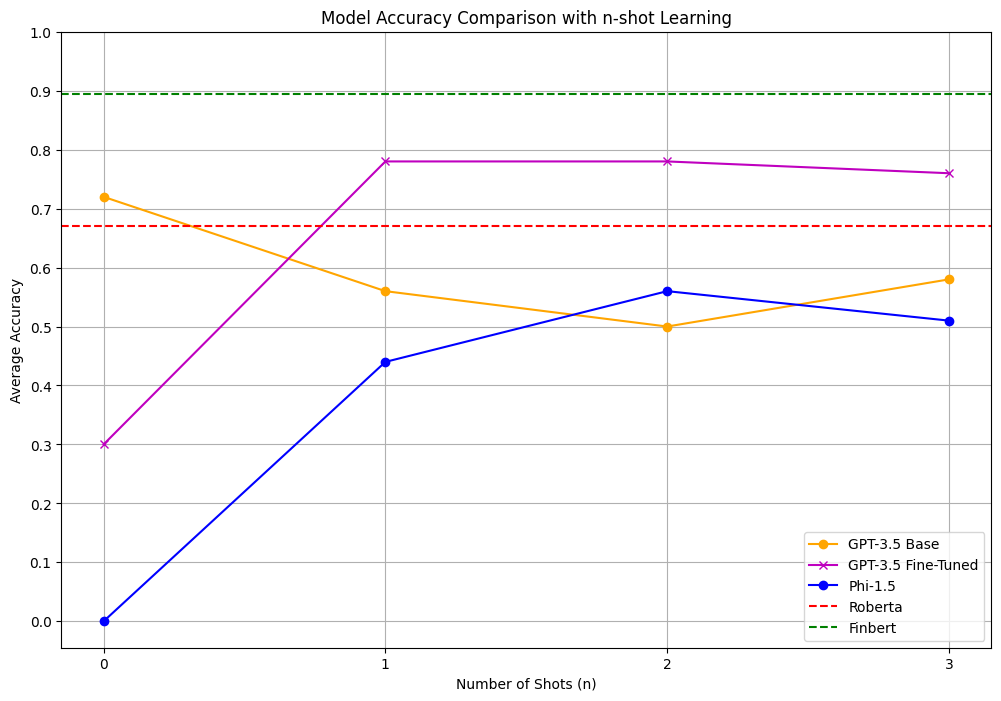